# SQD and SKQD

In this chapter, we'll explore how quantum and classical computers work together to solve one of the most important challenges in science: accurately estimating the energy of molecules and materials.

## Hamiltonian

The key to this problem is a mathematical operator—the Hamiltonian, which represents the total energy of a system. For computational purposes, we can think of this Hamiltonian as a large matrix. The solutions we are looking for—specifically the system's ground state—are the lowest eigenvalues of this matrix. The challenge, however, is that for practical problems, this Hamiltonian matrix is very large. It grows exponentially with the size of the system, quickly becoming too big (e.g., $2^n$ where $n$ is the number of qubits) for even the most powerful supercomputers to store or solve directly.

$$
H = \begin{pmatrix}
H_{0,0} & H_{0,1} & \cdots & H_{0,N-1} \\
H_{1,0} & H_{1,1} & \cdots & H_{1,N-1} \\
\vdots & \vdots & \ddots & \vdots \\
H_{N-1,0} & H_{N-1,1} & \cdots & H_{N-1,N-1}
\end{pmatrix} \quad (N=2^n)
$$

To get around this, we use a powerful strategy known as the subspace method. Instead of tackling the whole matrix, we intelligently select a small, relevant slice — a "subspace" — that we believe contains the most important information about the low-energy solution we're looking for.

$$
\underset{\text{Full Hamiltonian}}{\begin{pmatrix}
\ddots & \vdots \\
\cdots & H_{i,j} & \cdots \\
& \vdots & \ddots
\end{pmatrix}}
\quad \xrightarrow{\text{Project}} \quad
\underset{\text{Projected Hamiltonian}}{\tilde{H}}
= \begin{pmatrix}
\langle b_1 | H | b_1 \rangle & \cdots & \langle b_1 | H | b_L \rangle \\
\vdots & \ddots & \vdots \\
\langle b_L | H | b_1 \rangle & \cdots & \langle b_L | H | b_L \rangle
\end{pmatrix}
\quad \xrightarrow{\text{Diagonalize}} \quad
\underset{\text{Eigenvalues}}{\begin{pmatrix}
E_0 & & 0 \\
& \ddots & \\
0 & & E_{L-1}
\end{pmatrix}}
$$

Once this small subspace is defined by a set of basis states $\{|b_i\rangle\}$, the full Hamiltonian is projected onto it to create the new, smaller matrix $\tilde{H}$. Each element of this matrix is calculated from the subspace basis states and the original Hamiltonian as in $\langle b_i | H | b_j \rangle$. This small matrix can then be easily diagonalized on a classical computer, and the resulting eigenvalues are our estimated energies.

As you might guess, the success of this entire approach heavily relies on choosing a "good" subspace. If our subspace does not accurately represent the true ground state, our final answer will be incorrect. This is where quantum computers come in: they allow us to prepare and sample from complex quantum states designed to identify these important subspaces. For truly massive problems, like complex chemical structures or binding sites, even the projected matrix may still be challenging to diagonalize. Thus, such problems are ideally-suited to leverage the strengths of both quantum and classical computing resources.

In the following sections, we will explore two advanced algorithms, SQD and SKQD, which leverage quantum mechanics to find and construct these subspaces. For a deeper dive, there is a [whole course](https://quantum.cloud.ibm.com/learning/en/courses/quantum-diagonalization-algorithms) on the IBM Quantum Platform devoted to these topics in detail. For our purposes in this course, we will keep the explanation at a high level.

## Sample-based Quantum Diagonalization

Sample-based Quantum Diagonalization (SQD) is a powerful variational algorithm that implements the subspace method in a quantum way. It avoids costly, complex procedures like Hadamard tests by using a quantum computer to prepare a trial state and sample *bitstrings*, which define the subspace for classical diagonalization.

![A schematic of the workflow specific to sample-based quantum diagonalization. The steps include a variational quantum circuit, using measurements to project the Hamiltonian into a subspace, then using a classical optimizer to update variational parameters in the circuit and repeating.](/learning/images/courses/integrating-quantum-and-high-performance-computing/sqd-skqd/sqd-cycle.svg)

The SQD algorithm can be broken down into the following steps:

#### Step 1: Prepare the Ansatz State

Let $H = \sum_{j=1}^Q \alpha_j P_j$ be the Hamiltonian on n qubits. While the true ground state may be supported on all $2^n$ basis states, SQD is most effective in instances where the ground state can be well-approximated by a sparse subspace (a polynomially-sized set of bitstrings).

To construct this subspace, we start with an input state $|\phi_0\rangle$, such as the Hartree-Fock (HF) state in chemistry. We then apply a parameterized quantum circuit, $U(\theta)$, which is known as the ansatz.

![A diagram showing the overlap of the computational basis states making up the ansatz and those making up the true ground state. Specifically, the image shows that the two regions will have some overlap, but might not perfectly match.](/learning/images/courses/integrating-quantum-and-high-performance-computing/sqd-skqd/ansatz.svg)

This diagram illustrates the goal of a good ansatz. The ansatz prepares a quantum state whose support (the set of basis states it is composed of) should ideally have a large overlap with the support of the true ground state. This circuit allows us to quickly project the ansatz onto computational basis states, which will be further used in classical diagonalization. In other words: we don't have to get guess an ansatz that is the ground state; we only need it to contain the same basis states. Then classical diagonalization of the projected Hamiltonian will give us the superposition of basis states that best approximates the ground state.
#### Step 2: Sample the Subspace

By sampling from the circuit prepared by the ansatz, we get a collection of bitstrings, $\{b_j\}_{j=1}^L$. These bitstrings define the basis of our chosen subspace. The quantum runtime for this step is determined by the depth of the circuit and the number of samples taken.

#### Step 3: Project and Diagonalize Classically

Using the sampled bitstrings, we project the Hamiltonian into the subspace they span. For each pair of bitstrings $(j, k)$, we classically compute the matrix element $\tilde{H}_{jk} = \langle b_j | H | b_k \rangle$. Because Pauli operators are sparse, this step is classically efficient for physical Hamiltonians. The resulting small matrix $\tilde{H}$ is then diagonalized on a classical processor to estimate the ground state and its energy.

#### Step 4: Optimize the Ansatz (Optional)

The process can be made iterative. By treating the estimated ground state energy as a cost function, we can optimize the circuit parameters ($\theta$) via methods like gradient descent to improve the ansatz, and in turn, the energy approximation in the next iteration.

### Key Advantages of SQD

SQD offers several powerful features that make it a leading candidate for demonstrating quantum advantage:

* Strong Robustness to Noise: Suppose the true ground state is supported on only two bitstrings. If these are sampled at all, even if their overlap with our ansatz is small, the diagonalization will assign them the appropriate weights and effectively ignore all other extraneous, noisy bitstrings that might have also been sampled. This inherent filtering makes SQD particularly noise-tolerant.
* Classical Verifiability: Unlike QPE or VQAs, SQD yields a classical approximation to the ground state. This means anyone with access to the list of bitstrings and their weights can recompute and verify the energy estimate directly on a classical computer.

SQD has already been used to estimate the ground-state dissociation energy of N2 and the electronic properties of [2Fe-2S] and [4Fe-4S] clusters [2], with circuits as large as 77 qubits and 10,570 gates.


#### Check your understanding
<details>
<summary>

True or False? SQD can be applied to chemical systems?

</summary>

__Answer:__

True
</details>

#### Check your understanding
<details>
<summary>

Call the set of all computational basis states that make up your ansatz $A$. Call the set of all computational basis states that make up the true ground state of your system $G$. Which of the following corresponds to a "good" ansatz? Select all that apply.

(a) $A \subset G \\$
(b) $A \subseteq G\\$
(c) $G \subset A\\$
(d) $G \subseteq A\\$
</summary>

__Answer:__

(c) and (d)
</details>

## SKQD (Sample-based Krylov Quantum Diagonalization)

Sample-based Krylov Quantum Diagonalization (SKQD) is another powerful quantum sample-based algorithm that builds upon the principles of SQD. While its goal is the same—to find a good subspace for diagonalization—SKQD employs a more structured method for generating the bitstrings, especially for problems like lattice Hamiltonians.

The core idea of SKQD is that instead of optimizing a parameterized circuit to find a good ansatz, one can provably converge to the ground state by sampling from a set of states generated by the system's own natural time evolution - the Krylov subspace. The SKQD algorithm can be broken down into the following steps:

#### Step 1: Construct the Krylov Subspace via Time Evolution

The process begins with an initial state $|\phi_0\rangle.$ Importantly, we do not need this initial state to have a "good" overlap with the ground state. It only needs to be "polynomially large", or described by a polynomial in system size. The algorithm itself will then drive the state closer and closer to the ground state of the system. SKQD applies the time evolution operator, $e^{-iHt}$, for different lengths of time. This creates a set of $d$ different quantum states, defined as:

$$
|\phi_j\rangle = e^{-i \,\delta t j H}|\phi_0\rangle,  \quad \text{for } j = 0, 1, \dots, d-1 \quad \text{}
$$


This collection of time-evolved states forms a Krylov basis. This step is particularly effective for lattice Hamiltonians where the number of terms in the Hamiltonian is not large. For chemistry problems, this time evolution can result in very deep circuits, which is why SQD is often recommended for those cases.

#### Step 2: Sample from the Krylov Basis States

Next, bitstring samples are collected from each of the $d$ different states ($|\phi_0\rangle, |\phi_1\rangle, \dots, |\phi_{d-1}\rangle$) prepared in the previous step. All of these bitstrings are then pooled together to form the basis for the subspace.

#### Step 3: Project and Diagonalize Classically

This step is identical to the one in SQD. The collected bitstrings are used to project the full Hamiltonian into the subspace they span. The resulting small matrix, $\tilde{H}$, is then diagonalized on a classical computer to find the ground state energy.

### Key Advantages and Guarantees of SKQD

SKQD's structured approach provides unique benefits:

* Provable Convergence: SKQD's key advantage is its theoretical guarantee of convergence under specific, well-defined conditions. If the true ground state is sparse (can be well-approximated by a polynomial number of bitstrings) and the energy gap to the first excited state is not too small, the method is proven to work efficiently. Under these conditions, SKQD guarantees that it will find the crucial bitstrings that make up the ground state and can approximate the ground state energy to high accuracy. This requires only a polynomial number of quantum experiments and shots. This guarantee places the sample-based approach on a rigorous theoretical footing, similar to established methods like Quantum Phase Estimation.

* Shared Benefits with SQD: Similar to SQD, SKQD also has the noise robustness property. In other words, as long as one has all the good bitstrings in the set of sampled bitstrings, diagonalization assigns almost zero weight to incorrect bitstrings, making the procedure robust to noise. Moreover, since the solution is produced from a classical HPC, the energy of the solution is classically verifiable.

In experiments, SKQD has been used with up to 70 qubits and thousands of gates to study the ground state of complex 4-impurity Anderson models, achieving excellent agreement with state-of-the-art classical methods like DMRG. [1]

#### Check your understanding
<details>
<summary>

What part of the SKQD algorithm makes it more amenable to physical problems like spin lattices than to chemical problems? Why?

</summary>

__Answer:__

The time evolution requires trotter circuits, which are very deep for Hamiltonians that are complicated and not sparse. Spin lattice interactions are governed by spin matrices, equivalent to Pauli matrices. Thus the Hamiltonians for spin lattices tend to be more compactly expressible in Pauli matrices, especially those with nearest neighbor interactions.

</details>

## SQD and SKQD as a Heterogeneous Computing

To bring it all together, we can represent sample-based algorithms as a combination of different programming models on a set of heterogeneous resources. For example, we can represent our algorithm as a task workflow.

![A schematic of the workflow specific to sample-based quantum diagonalization. The steps include a variational quantum circuit, using measurements to project the Hamiltonian into a subspace, then using a classical optimizer to update variational parameters in the circuit and repeating.](/learning/images/courses/integrating-quantum-and-high-performance-computing/sqd-skqd/sqd-workflow.svg)

This figure illustrates the fundamental four-stage workflow. At first, we will have a task for quantum circuit preparation that overlaps with our target state, followed by task for transpilation, which only requires classical resources to be executed. Next will be a task that uses primitives to execute our quantum circuit, which obviously will require quantum resources. And then we have a post-processing task, which itself might be a parallel diagonalization algorithm running on multiple nodes.

Additionally, we might want to run one of these algorithms many times while we vary our ansatz or/and run them completely in parallel with different populations.

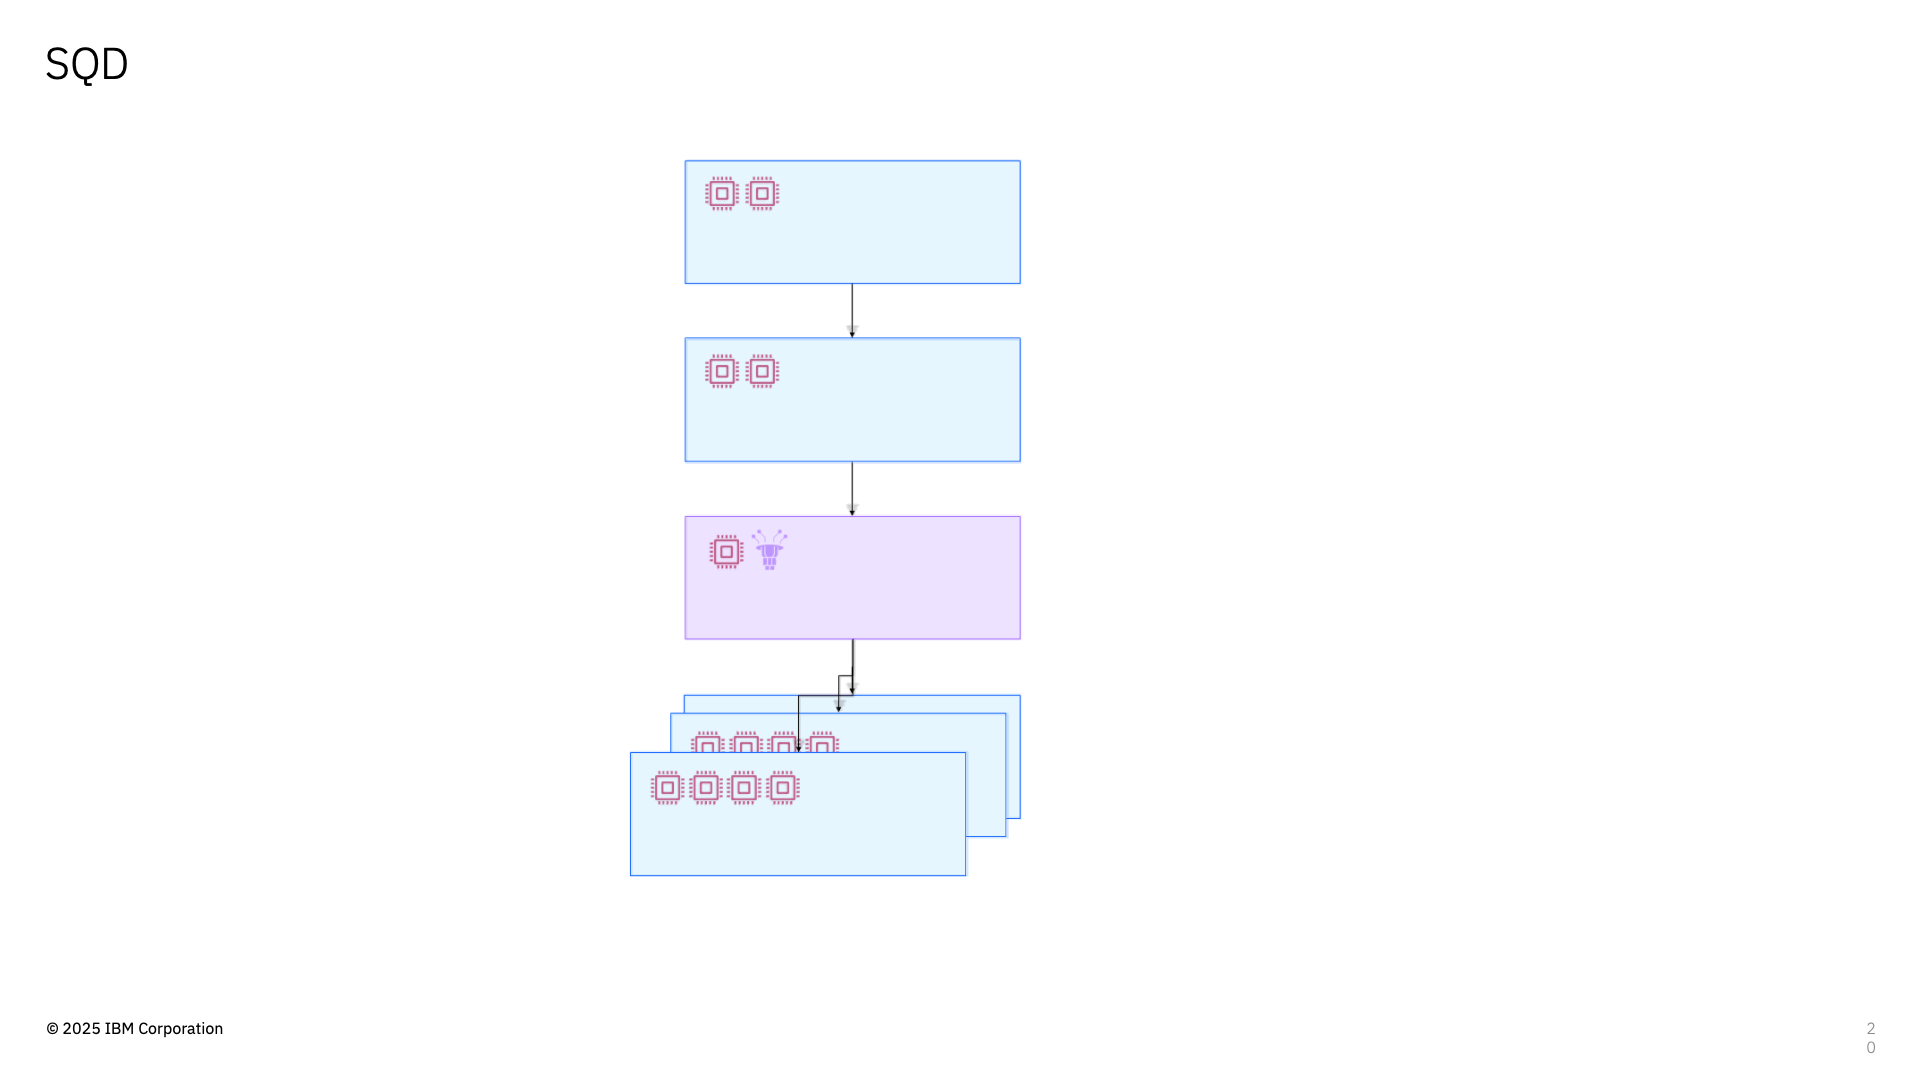
![A schematic of an sqd workload being split among several resources. It shows several processes running sequentially, using the results of one iteration to inform the next, but also performing many such processes in parallel.](/learning/images/courses/integrating-quantum-and-high-performance-computing/sqd-skqd/sqd-complex.svg)

As depicted above, one might run multiple workflows simultaneously while:

* Varying the parameters or the structure of the ansatz to find the most effective one.
* Starting with different initial states or configurations ("populations") to avoid local minima and ensure a more robust result.

This multi-layered approach, combining task-based heterogeneity with workflow-level parallelism, is key to unlocking the full potential of these algorithms.

## Programming practice

Let's practice SKQD algorithm, demonstrating the heterogeneous workflow described previously. The process is broken down into four distinct stages, each with its own Python script and a corresponding shell script for job submission.

### Mapping (`mapping.py` and `mapping.sh`)

The first step in our workflow is to define the physical problem and map it to a set of quantum circuits.

The `mapping.py` defines the parameters for a specific physics problem—in this case, an Anderson impurity model with 7 bath sites (`n_bath = 7`). It constructs the one-body (`h1e`) and two-body (`h2e`) integrals that represent the system's Hamiltonian.

```python

...

n_bath = 7  # number of bath sites

...

# One body matrix elements in the "position" basis
h1e = -t * np.diag(np.ones(n_bath), k=1) - t * np.diag(np.ones(n_bath), k=-1)
h1e[impurity_index, impurity_index + 1] = -V
h1e[impurity_index + 1, impurity_index] = -V
h1e[impurity_index, impurity_index] = eps

# Two body matrix elements in the "position" basis
h2e = np.zeros((n_bath + 1, n_bath + 1, n_bath + 1, n_bath + 1))
h2e[impurity_index, impurity_index, impurity_index, impurity_index] = U

...

# The one-body time evolution
free_fermion_evolution = ffsim.qiskit.OrbitalRotationJW(n_modes, Utar)

# The two-body time evolution
def append_diagonal_evolution(dt, U, impurity_qubit, num_orb, q_circuit):
    """Append two-body time evolution to a quantum circuit."""
    if U != 0:
        q_circuit.append(
            CPhaseGate(-dt / 2 * U),
            [impurity_qubit, impurity_qubit + num_orb],
        )

```
It then generates the quantum circuits required for the SKQD algorithm. It starts by creating an initial state (`initial_state`) and then applies time-evolution operators for varying numbers of steps (`d = 8`) to generate the different Krylov basis states, $|\phi_j\rangle = (e^{-iHt})^j |\phi_0\rangle$.

```python

# The reference state
def initial_state(q_circuit, norb, nocc):
    """Prepare an initial state."""
    for i in range(nocc):
        q_circuit.append(XGate(), [i])
        q_circuit.append(XGate(), [norb + i])
    rot = XXPlusYYGate(np.pi / 2, -np.pi / 2)

    for i in range(3):
        for j in range(nocc - i - 1, nocc + i, 2):
            q_circuit.append(rot, [j, j + 1])
            q_circuit.append(rot, [norb + j, norb + j + 1])
    q_circuit.append(rot, [j + 1, j + 2])
    q_circuit.append(rot, [norb + j + 1, norb + j + 2])

...

# Generate the initial state
qubits = QuantumRegister(2 * n_modes, name="q")
init_state = QuantumCircuit(qubits)
initial_state(init_state, n_modes, n_modes // 2)

...

d = 8  # Number of Krylov basis states
circuits = []
for i in range(d):
    circ = init_state.copy()
    circuits.append(circ)
    for _ in range(i):
        append_diagonal_evolution(dt, U, impurity_index, n_modes, circ)
        circ.append(free_fermion_evolution, qubits)
        append_diagonal_evolution(dt, U, impurity_index, n_modes, circ)
    circ.measure_all()

print(circuits[0].draw(scale=0.4, fold=-1))

```
The script saves the list of 8 generated circuits (each with measurements appended) to a file named `circuits.qpy`.

The `mapping.sh` is a SLURM batch script used to submit the `mapping.py` job. Since this is a classical computation, it requests resources from a standard CPU partition (`--partition=normal`).

```shell
#!/bin/bash
#
#SBATCH --job-name=sqd-mapping
#SBATCH --output=sqd-mapping.out
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=1
#SBATCH --partition=normal


srun python /data/ch4/sqd/mapping.py
```

### Optimization (`optimization.py` and `optimization.sh`)

Once we have our circuits, they must be optimized and compiled to run efficiently on the target quantum hardware.

In the `optimization.py`, this script first loads the `circuits.qpy` file created in the mapping stage and bring quantum resource information by `QRMI()`, a quantum resource manager. Then it uses Qiskit's `generate_preset_pass_manager` with a high optimization level (`optimization_level=3`) to convert the abstract, logical circuits into Instruction Set Architecture (ISA) circuits. This process rewrites the circuits using the native gates of the hardware and optimizes them to reduce depth and minimize errors.

```python

...
qrmi = QRMI()
resources = qrmi.resources()
quantum_resource = resources[0]
target = quantum_resource.target

pass_manager = generate_preset_pass_manager(
    optimization_level=3,
    target=target
)
isa_circuits = pass_manager.run(circuits)

```

The transpiled, hardware-ready circuits are saved to a new file, `isa_circuits.qpy`.

Similar to the mapping script, this SLURM job also runs on a classical CPU partition (`--partition=normal`) as transpilation is a classical task.

```shell
#!/bin/bash
#
#SBATCH --job-name=sqd-mapping
#SBATCH --output=sqd-mapping.out
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=1
#SBATCH --partition=normal


srun python /data/ch4/sqd/mapping.py
```

### Execution (`execution.py` and `execution.sh`)

This is the only stage where a quantum computer is used. Here, we execute the optimized circuits and collect measurement samples.

The `execution.py` loads the optimized `isa_circuits.qpy` file then initializes a `SamplerV2` primitive that is connected to a quantum resource. It then calls `sampler.run()` to execute the circuits on the QPU for a specified number of shots (`shots=500`).

```python

...

qrmi = QRMI()
resources = qrmi.resources()
quantum_resource = resources[0]

# Sample from the circuits
noisy_sampler = Sampler(quantum_resource)
job = noisy_sampler.run(isa_circuits, shots=500)

```
At the end of execution, the measured results (bitstrings) from all the circuits are collected, combined, and their counts are saved to a `counts.json` file.


The SLURM script `execution.sh` is different from the others at this stage. It requests to be run on the quantum partition (`--partition=quantum`) and specifically requests one QPU (`--gres=qpu:1`).

```shell
#!/bin/bash
#
#SBATCH --job-name=sqd-execution
#SBATCH --output=sqd-execution.out
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=1
#SBATCH --partition=quantum
#SBATCH --gres=qpu:1


srun python /data/ch4/sqd/execution.py
```

### Post-processing (`postprocessing.py` and `postprocessing.sh`)

In the final step, we return to a classical computer to analyze the data from the quantum experiment and calculate the final result - the ground state energy of our target system.

In the `postprocessing.py`, it first reads the `counts.json` file containing the measurement results. Then it reconstructs the Hamiltonian of the Anderson model (using the same parameters as in `mapping.py`). It then passes the measured bitstrings and the Hamiltonian definition to the `diagonalize_fermionic_hamiltonian` function. This function performs the core SKQD logic: it uses the bitstrings to construct the projected Hamiltonian $\tilde{H}$ and diagonalizes it to find the ground state energy.

```python

...

def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")


rng = np.random.default_rng(24)
result = diagonalize_fermionic_hamiltonian(
    h1e,
    h2e,
    bit_array,
    samples_per_batch=300,
    norb=n_modes,
    nelec=nelec,
    num_batches=3,
    max_iterations=10,
    symmetrize_spin=True,
    callback=callback,
    seed=rng,
)

```

Finally, this prints the calculated SKQD energy and compares it to the known exact energy for this problem, showing the final absolute error of the computation.

The final job script runs on a classical partition (`--partition=normal`), as all the analysis is classical. For large subspaces, this step might require more classical HPC resources.

```shell
#!/bin/bash
#
#SBATCH --job-name=sqd-postprocessing
#SBATCH --output=sqd-postprocessing.out
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=1
#SBATCH --partition=normal


srun python /data/ch4/sqd/postprocessing.py
```

## Recap

And that's it! We've now run through few concepts and examples that can help you get started with the management of complex hybrid programs. Of course, a video like this only scratches the surface of everything you can do with the combination of quantum and classical HPC resources.

To explore more use cases and algorithms, take a look at our documentation and tutorials on IBM Quantum Platform, and be sure to check the resources shared in the text section for more info on algorithms and software for both computational scientists and datacenter administrators.

## References

[1] : Quantum-Centric Algorithm for Sample-Based Krylov Diagonalization. https://arxiv.org/abs/2501.09702
[2] : Chemistry beyond the scale of exact diagonalization on a quantum-centric supercomputer. https://www.science.org/doi/10.1126/sciadv.adu9991